# Bayesian Inference with Differentiable Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/docs/notebooks/bayesian_inference.ipynb)

This tutorial demonstrates how to perform Bayesian inference on epidemiological model parameters using **emidm**'s differentiable models and BlackJAX for Hamiltonian Monte Carlo (HMC) sampling.

## Why Bayesian Inference?

While gradient-based optimization (as shown in the calibration tutorial) gives us point estimates, Bayesian inference provides:

1. **Uncertainty quantification**: Full posterior distributions over parameters
2. **Prior incorporation**: Include domain knowledge about plausible parameter values
3. **Model comparison**: Compare models via marginal likelihoods

## Setup

This tutorial requires JAX and BlackJAX:

```bash
pip install emidm[jax] blackjax
```

In [7]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

from emidm.diff import DiffConfig, run_diff_sir_simulation
from emidm.optim import mse_loss

# Show which device JAX is using
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# Check if blackjax is available
try:
    import blackjax
    HAS_BLACKJAX = True
except ImportError:
    HAS_BLACKJAX = False
    print("BlackJAX not installed. Install with: pip install blackjax")

JAX backend: gpu
JAX devices: [cuda(id=0)]


## Step 1: Generate Synthetic Data

We'll create synthetic epidemic data with known parameters, then try to recover them with uncertainty estimates.

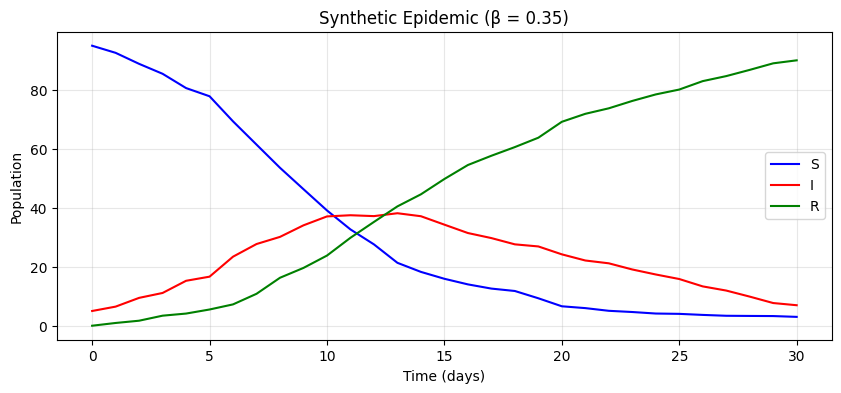

In [ ]:
# True parameters
BETA_TRUE = 0.35
GAMMA = 0.1
N = 100  # Smaller for faster demo
T = 30
I0 = 5

# Generate "observed" data
# Using hard=False for smoother gradients (better for HMC)
key = jax.random.PRNGKey(42)
observed = run_diff_sir_simulation(
    N=N,
    I0=I0,
    beta=BETA_TRUE,
    gamma=GAMMA,
    T=T,
    config=DiffConfig(tau=0.5, hard=False),
    key=key,
)

observed_I = observed["I"]

# Visualize
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(observed["t"], observed["S"], label="S", color="blue")
ax.plot(observed["t"], observed["I"], label="I", color="red")
ax.plot(observed["t"], observed["R"], label="R", color="green")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title(f"Synthetic Epidemic (β = {BETA_TRUE})")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Step 2: Define the Log-Posterior

For Bayesian inference, we need to define:

1. **Likelihood**: How probable is the observed data given parameters?
2. **Prior**: What do we believe about parameters before seeing data?

The posterior is proportional to: `posterior ∝ likelihood × prior`

In [ ]:
# For efficient MCMC, we use the public API with run_diff_sir_simulation
# The model is JIT-compiled internally for efficiency

# Fixed key for deterministic likelihood evaluation
likelihood_key = jax.random.PRNGKey(0)

@jax.jit
def _fast_sir(beta):
    """Fast SIR that only varies beta."""
    result = run_diff_sir_simulation(
        N=N,
        I0=I0,
        beta=beta,
        gamma=GAMMA,
        T=T,
        config=DiffConfig(tau=0.5, hard=False),
        key=likelihood_key,
    )
    return result["I"]

# Version that also takes a key - for posterior predictive sampling
def _fast_sir_with_key(beta, key):
    """Fast SIR with variable key for stochastic predictions."""
    result = run_diff_sir_simulation(
        N=N,
        I0=I0,
        beta=beta,
        gamma=GAMMA,
        T=T,
        config=DiffConfig(tau=0.5, hard=False),
        key=key,
    )
    return result["I"]

def log_posterior(beta):
    """Log-posterior using the fast pre-compiled model."""
    pred_I = _fast_sir(beta)
    # Gaussian likelihood
    sigma = 5.0
    ll = -0.5 * jnp.sum(((pred_I - observed_I) / sigma) ** 2)
    # Gaussian prior
    lp = -0.5 * ((beta - 0.3) / 0.15) ** 2
    return ll + lp

# JIT the full posterior
log_posterior_jit = jax.jit(log_posterior)

# Warm up JIT (one-time cost)
print("Compiling...")
_ = log_posterior_jit(jnp.array(0.3)).block_until_ready()
print("Done!")

# Test
print(f"Log-posterior at β=0.3: {log_posterior_jit(jnp.array(0.3)):.2f}")
print(f"Log-posterior at β=0.35 (true): {log_posterior_jit(jnp.array(BETA_TRUE)):.2f}")

Compiling...
Done!
Log-posterior at β=0.3: -10.61
Log-posterior at β=0.35 (true): -3.77


## Step 3: Run MCMC Sampling

We'll use BlackJAX's NUTS (No-U-Turn Sampler) algorithm, which is an adaptive form of Hamiltonian Monte Carlo that automatically tunes the step size and trajectory length.

In [10]:
if HAS_BLACKJAX:
    # Use NUTS for efficient sampling
    nuts = blackjax.nuts(
        log_posterior_jit, 
        step_size=0.01,
        inverse_mass_matrix=jnp.array([1.0])
    )
    initial_position = jnp.array(0.30)
    init_state = nuts.init(initial_position)
    
    # JIT compile the step function
    step_fn = jax.jit(nuts.step)
    
    # Compile (one-time cost)
    print("Compiling sampler...")
    _ = step_fn(jax.random.PRNGKey(0), init_state)
    
    # Sampling loop using scan for efficiency
    def one_step(state, rng_key):
        state, info = step_fn(rng_key, state)
        return state, state.position
    
    # Run sampling
    print("Running sampling (500 samples)...")
    n_samples = 500
    rng_key = jax.random.PRNGKey(123)
    keys = jax.random.split(rng_key, n_samples)
    final_state, samples = jax.lax.scan(one_step, init_state, keys)
    samples = np.array(samples)
    
    # Discard first 100 as burn-in
    samples = samples[100:]
    print(f"\nCollected {len(samples)} samples (after burn-in)")
    print(f"Posterior mean: {samples.mean():.4f}")
    print(f"Posterior std: {samples.std():.4f}")
    print(f"True value: {BETA_TRUE}")
else:
    print("Skipping MCMC - BlackJAX not installed")
    samples = None

Compiling sampler...
Running sampling (500 samples)...

Collected 400 samples (after burn-in)
Posterior mean: 0.3670
Posterior std: 0.0193
True value: 0.35


## Step 4: Analyze the Posterior

Let's visualize the posterior distribution and check convergence.

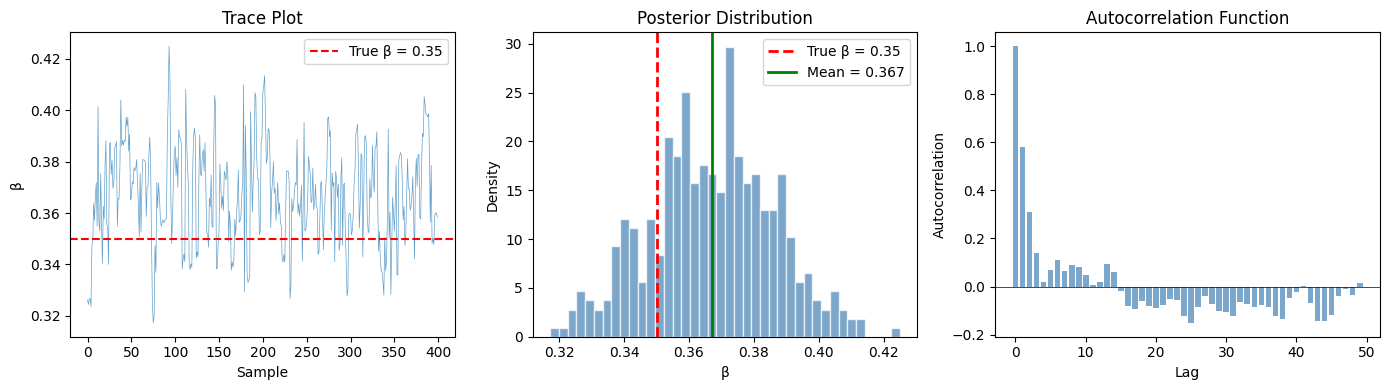


Posterior Summary:
  Mean: 0.3670
  Std:  0.0193
  2.5%: 0.3280
  97.5%: 0.4053
  True:  0.35


In [11]:
if samples is not None:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Trace plot
    ax = axes[0]
    ax.plot(samples, alpha=0.7, linewidth=0.5)
    ax.axhline(y=BETA_TRUE, color="red", linestyle="--", label=f"True β = {BETA_TRUE}")
    ax.set_xlabel("Sample")
    ax.set_ylabel("β")
    ax.set_title("Trace Plot")
    ax.legend()
    
    # Histogram
    ax = axes[1]
    ax.hist(samples, bins=40, density=True, alpha=0.7, color="steelblue", edgecolor="white")
    ax.axvline(x=BETA_TRUE, color="red", linestyle="--", linewidth=2, label=f"True β = {BETA_TRUE}")
    ax.axvline(x=samples.mean(), color="green", linestyle="-", linewidth=2, label=f"Mean = {samples.mean():.3f}")
    ax.set_xlabel("β")
    ax.set_ylabel("Density")
    ax.set_title("Posterior Distribution")
    ax.legend()
    
    # Autocorrelation
    ax = axes[2]
    max_lag = 50
    acf = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] if lag > 0 else 1.0 for lag in range(max_lag)]
    ax.bar(range(max_lag), acf, color="steelblue", alpha=0.7)
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.set_title("Autocorrelation Function")
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nPosterior Summary:")
    print(f"  Mean: {samples.mean():.4f}")
    print(f"  Std:  {samples.std():.4f}")
    print(f"  2.5%: {np.percentile(samples, 2.5):.4f}")
    print(f"  97.5%: {np.percentile(samples, 97.5):.4f}")
    print(f"  True:  {BETA_TRUE}")

## Step 5: Posterior Predictive Check

We can use samples from the posterior to generate predictions and visualize uncertainty in the model fit.

In [ ]:
if samples is not None:
    
    # Generate predictions from posterior samples
    n_pred = 100
    sample_indices = np.random.choice(len(samples), n_pred, replace=False)
    
    # Get beta samples and generate different keys for each prediction
    beta_samples = jnp.array(samples[sample_indices])
    pred_keys = jax.random.split(jax.random.PRNGKey(999), n_pred)
    
    # Vectorize over both beta and key using vmap
    predictions = jax.vmap(_fast_sir_with_key)(beta_samples, pred_keys)
    predictions = np.array(predictions)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Posterior predictive interval
    pred_mean = predictions.mean(axis=0)
    pred_lower = np.percentile(predictions, 2.5, axis=0)
    pred_upper = np.percentile(predictions, 97.5, axis=0)
    t = np.array(observed["t"])
    ax.fill_between(t, pred_lower, pred_upper, alpha=0.3, color="steelblue", label="95% CI")
    ax.plot(t, pred_mean, color="steelblue", linewidth=2, label="Posterior mean")
    ax.scatter(t, np.array(observed_I), color="black", s=30, zorder=5, label="Observed")
    ax.set_xlabel("Time (days)", fontsize=12)
    ax.set_ylabel("Number Infected", fontsize=12)
    ax.set_title("Posterior Predictive Check", fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
The problem arose with the `int` function. If trying to convert the data type of a value, try using `x.astype(int)` or `jnp.array(x, int)` instead.
The error occurred while tracing the function _fast_sir_with_key at /tmp/ipykernel_23412/3255625840.py:19 for jit. This concrete value was not available in Python because it depends on the value of the argument key.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

## Summary

In this tutorial, we demonstrated:

1. **Differentiable likelihood**: Using `run_diff_sir` to compute gradients through the epidemic model
2. **Bayesian inference**: Combining likelihood with priors to form a posterior
3. **MCMC sampling**: Using BlackJAX NUTS to sample from the posterior
4. **Posterior analysis**: Visualizing uncertainty and performing predictive checks

The key advantage of differentiable models is that HMC/NUTS can use gradient information to explore the posterior efficiently, which is especially important for:

- **High-dimensional problems**: Many parameters to estimate
- **Complex posteriors**: Multi-modal or correlated parameters
- **Expensive models**: Where efficient exploration is crucial